
# Setup

In [1]:
import torch
from torch import nn

import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import datetime

from config import *

In [2]:
TRAIN_DATA_PATH = 'dataset/train/'
TEST_DATA_PATH = 'dataset/test/'
MODEL_OUTPUT_PATH = 'models/'

LABELS = ('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')

EPOCHS = 10
BATCH_SIZE = 32

NR_OF_CATEGORIES = 7
NN_IMAGE_SIZE = 200

SAVE_LAST_MODEL = True

# Preparing the data loaders

In [3]:
image_transform = transforms.Compose([
    transforms.Resize((NN_IMAGE_SIZE, NN_IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=image_transform)
test_dataset = datasets.ImageFolder(root=TEST_DATA_PATH, transform=image_transform)

In [4]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_data_iter = iter(train_data_loader)

In [5]:
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_iter = iter(test_data_loader)

Display a random image

tensor(3)


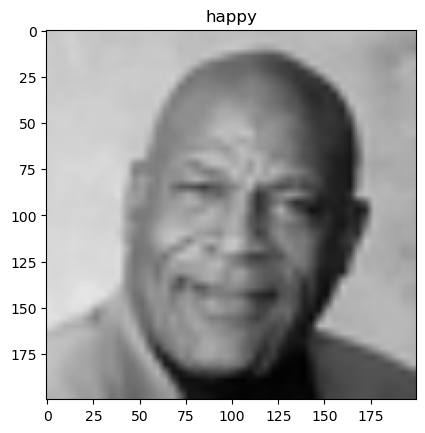

In [6]:
example_images, example_labels = next(train_data_iter)

random_index = torch.randint(0, BATCH_SIZE, size=[1]).item()
img, label = example_images[random_index], example_labels[random_index]

to_pil_image = transforms.Compose([
    transforms.ToPILImage()
])

pil_image = to_pil_image(img)

plt.imshow(pil_image)
plt.title(LABELS[label])

plt.show()

# Creating the model

In [14]:
class EmotionDetectorModel(nn.Module):
	def __init__(self):
		super().__init__()
		
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
		self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

		self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
		self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

		# the window size is 200, then after using max pooling it's 50
		new_size = NN_IMAGE_SIZE // 4

		self.fc1 = nn.Linear(32 * new_size * new_size, 128)
		self.fc2 = nn.Linear(128, NR_OF_CATEGORIES)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = self.max_pool1(x)

		x = F.relu(self.conv2(x))
		x = self.max_pool2(x)

		# flatten the output for the fully connected layers
  
		new_size = NN_IMAGE_SIZE // 4
		x = x.view(-1, 32 * new_size * new_size)

		x = F.relu(self.fc1(x))
		x = F.softmax(self.fc2(x), dim=1)

		return x

# Training the model

In [15]:
model = EmotionDetectorModel()

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()

In [19]:
best_test_loss = 10000.0

for epoch in range(EPOCHS):
	running_loss = 0.0
	model.train(True)

	for index, data in enumerate(train_data_loader):
		inputs, labels = data

		optimizer.zero_grad()

		outputs = model(inputs)
		loss = loss_function(outputs, labels)
		
		optimizer.step()

		running_loss += loss.item()

	average_loss = running_loss / BATCH_SIZE

	if epoch % 5 == 0:
		print(f'Epoch #{epoch} results:')
		print(f'\tAverage loss: {average_loss}')

	model.eval()

	with torch.no_grad():
		running_test_loss = 0.0

		for index, test_data in enumerate(test_data_loader):
			test_inputs, test_labels = test_data

			test_outputs = model(test_inputs)
			test_loss = loss_function(test_outputs, test_labels)

			running_test_loss += test_loss.item()

		average_test_loss = running_test_loss * (index + 1)
		print('\tAverage test loss: {test_average_loss}')
		
	if not SAVE_LAST_MODEL and average_test_loss < best_test_loss:
		best_test_loss = average_test_loss

		timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
		model_path = f'{MODEL_OUTPUT_PATH}/model_{epoch}_{timestamp}'

		torch.save(model.state.dict(), model_path)

if SAVE_LAST_MODEL:
	timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
	model_path = f'{MODEL_OUTPUT_PATH}/model_{epoch}_{timestamp}'

	torch.save(model.state.dict(), model_path)


898


KeyboardInterrupt: 

# Testing on a random batch

In [ ]:
example_images, example_labels = next(test_data_iter)

for index in range(BATCH_SIZE):
    img, label = example_images[random_index], example_labels[random_index]

    to_pil_image = transforms.Compose([
        transforms.ToPILImage()
    ])

    pil_image = to_pil_image(img)

    plt.imshow(pil_image)
    plt.title(LABELS[label])

plt.show()